In [1]:

import pyvo as vo
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.utils.data import download_file
from astropy.io import fits
from astropy.table import Table
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
from photutils.utils import calc_total_error
import pandas as pd
from scipy.spatial import KDTree
import json


from scipy.optimize import curve_fit
from photutils.detection import DAOStarFinder
from astropy.stats import mad_std, sigma_clipped_stats
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import math

In [2]:
%matplotlib inline

# initialization of flux values so i can debug:


In [ ]:




####Defining the constants

#define coordinates	
ra= 359.45700000000016
dec= -32.592000000000013
pos = SkyCoord(ra=ra, dec=dec, unit= 'deg')
print(pos)

# Lookup and define a service for ALLWISE Atlas images
# the website gave me the URL
allwise_service = vo.dal.SIAService("https://irsa.ipac.caltech.edu/ibe/sia/wise/allwise/p3am_cdd?")

#search the service for images covering within 1 arcsecond of the star. make this bigger if needed
im_table = allwise_service.search(pos=pos, size= 1*u.arcsec)
#im_table
im_table.to_table().colnames
for i in range(len(im_table)):
    print(im_table[i])


   #grab the x-ray sources for this galaxy
#import huge csv and grab the name and ra and dec needed for each source.
targetgals = pd.read_csv('../Data/inWISE.csv') # this should not be the one for all 120 and should rather be for the 74 of them.
print(targetgals[0:20])
huge = pd.read_csv('../Data/Hugefiles/Source_Flux_All_Modified_5.csv')
columns = ['RA','Dec', 'Gname_Modified','Gname_Homogenized']
g_huge = huge[columns]
g_huge[0:100]

#locate through merging
df1 = targetgals
df2 = g_huge

merged_data = pd.merge(df1, df2, left_on='source_id', right_on = 'Gname_Homogenized', how='inner')
columns = ['RA','Dec','Gname_Homogenized']
Xray_sources = merged_data[columns]
Xray_sources

# just want NGC 7793s sources
sources_7793 = Xray_sources.loc[Xray_sources['Gname_Homogenized'] == 'NGC 7793']
#sources_7793
#define the X-ray sources of NGC 7793
ra = sources_7793['RA'].values
dec = sources_7793['Dec'].values
#print(ra)

# defining a function to calculate the distances between two sources.
def dist(p1, p2):
    return np.sqrt( (p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )

#defining a function that creates a circular mask around each source so that if something overlaps with it, that overlapping part is not included in the aperture photometry
def create_circular_mask(h,w,center,radius):
    Y, X = np.ogrid[:h, :w] # creating an open (more memory efficient) coordinate grid of the image
    dist_from_center = np.sqrt((X-center[0])**2+ (Y-center[1])**2)
    mask = dist_from_center <= radius # so that everything inside the radius receives a mask
    return mask

# define a mapping of the bands into labels to make it easier
band_labels = {'w1': 'W1', 'w2': 'W2', 'w3': 'W3', 'w4': 'W4'}
flux_zmfd = {'w1': 309.54 ,'w2': 171.787,'w3': 31.674,'w4': 8.363} # check if these worked by looking at the band 4 code above
instr_zpmag = {'w1': 20.73,'w2': 19.56,'w3': 17.6 ,'w4':12.98 }
wavelengths = {'w1': 3.4 ,'w2': 4.6,'w3': 12,'w4': 22}

#define function to get flux density per unit frequency (energy units)
def flux_dens(net_flx, net_flx_err, wavelength):
    flux_density = (net_flx * 1e-23) * (3e10 / (wavelength*1e-4)**2)
    flux_density_unc = (net_flx_err * 1e-23) * (3e10 / (wavelength*1e-4)**2)
    return flux_density, flux_density_unc


##running the for loop over every image and doing aperture photometry on each one
#currently outputs as w4,w1,w2,w3 when querying the images. so index is 0.1.2.3 i want the index to be 0.3.2.1
rows = []
for i in [0, 3, 2, 1]:  # Reverse order index
    band_id = im_table[i]["sia_bp_id"].lower()  # Get band ID in lowercase

    if band_id in band_labels:
        print(f'Band {band_labels[band_id]}: ')
        data_url = im_table[i].getdataurl()
        #Download the image and open it in Astropy
        fname = download_file(data_url, cache=True)
        image1= fits.open(fname)
        image_data= image1[0].data
        #print(data)
        
        wcs = WCS(image1[0].header)
        #cuting out the image of the galaxy apart from the rest of the background.
        cutout = Cutout2D(image_data, pos, (437,437), wcs=wcs)
        wcs = cutout.wcs
        cutout_data = cutout.data
        #print(cutout_data)
        positions = wcs.world_to_pixel_values(ra, dec)
        positions = np.array(list(zip(positions[0], positions[1])))

        #define the distance threshold for the KDTree grouping (in pixels)
        distance_threshold = 5

        #build the KDTree for efficient grouping
        tree = KDTree(positions)

        #query the KDTree to find points within the defined radius of dist threshold and group them together
        groups = tree.query_ball_tree(tree, r=distance_threshold)
       # print(groups)
        # consolidating the groups. 'unique_groups' and 'seen': These are used to ensure that each group is processed only once.
        unique_groups = []
        seen = set()
        for group in groups:
            group = tuple(sorted(group))
            if group not in seen:
                seen.add(group)
                unique_groups.append(group)
       # print(unique_groups)
        # for each unique group, the average postion of the detections is calulated so that only one source detection is used for aperture photometry instead of a bunch of the same sources being used.
        #represents the consolidated postion of potentially multiple detections of one source.
        grouped_positions = [positions[list(group)].mean(axis=0) for group in unique_groups]
        #print(grouped_positions)

        #define the Region(s) Of Interest (center x, center y, radius)
        ROI = [ ((x, y) , 9, 16, 23) for x,y in grouped_positions ] # (x, y, radius around target, inner r, outer r)   36.3636, 50.90909) may need to mke the radius bigger when goruping? 
        

        # initialize valid rows plotting for the current image iteration
        valid_rows = []
        
        #now inputting the aperture photometry part
        # check for overlap and perform aperture photometry
        for i, ((x, y), r, annulus_inner, annulus_outer) in  enumerate(ROI):
            overlap = False# initialize overlap flag (A boolean flag overlap is set to False for each source to track if it overlaps with any other source.)
            non_overlapping_mask = create_circular_mask(cutout_data.shape[0], cutout_data.shape[1], (x,y), r)

            for j, ((x2, y2), r2, annulus_inner2, annulus_outer2) in  enumerate(ROI): # apparently you can run a for loop over 2 objects by putting the second one inside the first. it iterates over every source again to then see if it overlaps at all with another source.
                if i != j: # ensures that a source is not compared to itself! wow
                    distance = dist((x, y) , (x2, y2)) 
                    if distance < r + r2:  # if the distance is less than the size of the two radii added together, then they are overlapping.
                        overlap_percent = (r + r2 - distance)/(r+r2)  # the amount they are overlapping divided by the total size of radii distance
                        if overlap_percent > .5:
                            overlap = True # this way, if they overlap by more than 50% then they will not be usable because less than 50% of the flux extractable area can be seen.
                            overlap_mask = create_circular_mask(cutout_data.shape[0], cutout_data.shape[1], (x2,y2), r2)
                            non_overlapping_mask = np.logical_and(non_overlapping_mask, np.logical_not(overlap_mask)) # so that the overlapping part is read as false and thus excluded from calculation of flux.
                            # "logical and and not" are used to exclude certain regions such as the overlapping part! the logical not makes it so that 
                            # values that were once true in the overlap mask are not false, and the logical_and is there so that only the true values are accepted. effectively rejecting the part the overlapping mask covers.

                            #Handle overlaps that are acceptable (less than the threshold, but still overlapping by a small percent)
                            overlap_aperture = CircularAperture((x2, y2), r2)
                            overlap_photo_table = aperture_photometry(cutout_data, overlap_aperture)
                            overlap_counts = overlap_photo_table['aperture_sum'][0] 
                            overlap_error = np.sqrt(overlap_counts)
                            
                        else: 
                            overlap_mask = create_circular_mask(cutout_data.shape[0], cutout_data.shape[1], (x2,y2), r2)
                            non_overlapping_mask = np.logical_and(non_overlapping_mask, np.logical_not(overlap_mask))
                            overlap_aperture = CircularAperture((x2, y2), r2)
                            overlap_photo_table = aperture_photometry(cutout_data, overlap_aperture)
                            overlap_counts = overlap_photo_table['aperture_sum'][0] 
                            overlap_error = np.sqrt(overlap_counts)
                            
            if overlap:
                # For the Target objects in the little aperture circle define their target apertures
                target_aperture = CircularAperture((x,y),r,)
            
                #perform aperture photometry on target
                target_photo_table = aperture_photometry(cutout_data, target_aperture) 
                target_counts = target_photo_table['aperture_sum'][0]
                target_counts -= overlap_counts

                # so that i dont take the log or sqrt of a negative number or zero and get an error
                if target_counts > 0: # 
                    target_error= np.sqrt(target_counts)
                    #propagated error of overlap error
                    target_overlap_counts_err = np.sqrt(target_error**2 + overlap_error**2)
                    #print(target_counts)
                    if band_id in flux_zmfd and instr_zpmag: 
                         #print(f'Band {flux_zmfd[band_id]}: ')
                         flx_conv_fact = flux_zmfd[band_id]
                         M0instr = instr_zpmag[band_id]
                         Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
                         target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
                         
                         #propagation of uncertainty of flux conversion
                         Mcal_error = (2.5*target_overlap_counts_err) / (target_counts * np.log(10))
                         target_flux_error = target_flux * np.log(10) * (Mcal_error/2.5)

                else:
                         # to handle the cases where the counts are not more than 0 and if the conversion factors are missing.
                        rows.append({ 'band_id': {band_labels[band_id]},'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                        'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx, 'Flux Uncertainty': [], 'Flag':'Negative Target Counts',
                        'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux,
                            'Annulus Counts': annulus_counts, 'Overlap Counts': overlap_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': cutout_data.shape, 'Mask Shape': non_overlapping_mask.shape,
                            'Mask Type': non_overlapping_mask.dtype, 'Non-zero mask elements': np.count_nonzero(non_overlapping_mask), 'Flux Conv':flx_conv_fact, 'MzpInstr':M0instr,
                            'Offset in Arcseconds': [],  'Exists?': 'No', 'Point Source Position' : [], 'Target Error': target_flux_error, 'Annulus Error': annulus_flux_error, 'Overlap Error (in counts)': overlap_error, 'Wavelength': wavelengths[band_id], 'Flux Density': [], 'Flux Density Uncertainty' : []  })

                    
                #calculate area of target aperutue
                target_area = target_aperture.area




                # For the Background Annuli of outside of the Target
                #define the background annulus for the target
                annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

                #perform aperture photometry on annuli
                annulus_photo_table = aperture_photometry(cutout_data, annulus_aperture)
                annulus_counts = annulus_photo_table['aperture_sum'][0]
                
            
                if annulus_counts > 0:
                    overlapannulus_error = np.sqrt(annulus_counts) # the error of the annulus for sources that overlap
                     # to avoid taking the log of zero or negative value
                    if band_id in flux_zmfd and instr_zpmag: 
                         #print(f'Band {flux_zmfd[band_id]}: ')
                         flx_conv_fact = flux_zmfd[band_id]
                         M0instr = instr_zpmag[band_id]
                         Mcal_trgt = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
                         annulus_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux

                         #propagation of uncertainty of flux conversion
                         Mcal_error_ann = (2.5 * overlapannulus_error) / (annulus_counts * np.log(10))
                         annulus_flux_error = annulus_flux * np.log(10) * (Mcal_error_ann/2.5)


                else:
                        annulus_flux = np.nan # to handle the cases where the counts are not more than 0 and if the conversion factors are missing.
                        
                #calculate area of annulus
                annulus_area = annulus_aperture.area

                # do the calculations for including a Background aperture
            
                #Calculating the net flux:
                #calculate the mean background per pixel
                bg_perpixel = annulus_flux/annulus_area
                bg_perpixel_err = annulus_flux_error/annulus_area #propagation of error!

                #calculate the total background in the target aperture
                tot_bg = bg_perpixel * target_area
                tot_bg_err = bg_perpixel_err * target_area ##propagation of error!

                #Subtract background from the target flux
                net_flx = target_flux - tot_bg
                net_flx_err = np.sqrt(target_flux_error**2 + tot_bg_err**2) ##propagation of error!
            
                #flag the sources that overlap
                rows.append({ 'band_id': {band_labels[band_id]},'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                        'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx,'Flux Uncertainty': net_flx_err, 'Flag':'Valid' if not math.isnan(target_counts) and target_counts > 0 and net_flx > 0 else 'Low Flux',
                        'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux,
                            'Annulus Counts': annulus_counts, 'Overlap Counts': overlap_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': cutout_data.shape, 'Mask Shape': non_overlapping_mask.shape,
                            'Mask Type': non_overlapping_mask.dtype, 'Non-zero mask elements': np.count_nonzero(non_overlapping_mask), 'Flux Conv':flx_conv_fact, 'MzpInstr':M0instr, 
                            'Offset in Arcseconds': [], 'Exists?': 'No', 'Point Source Position' : [], 'Target Error': target_flux_error, 'Annulus Error': annulus_flux_error, 'Overlap Error (in counts)': overlap_error, 'Wavelength': wavelengths[band_id], 'Flux Density': [], 'Flux Density Uncertainty' : [] })
                # Append valid results to valid_rows
                valid_rows.append({
                    'band_id': {band_labels[band_id]},
                    'Region': i+1, 'X': x, 'Y': y, 'Radius': r,
                    'Annulus_Inner_Radius': annulus_inner,
                    'Annulus_Outer_Radius': annulus_outer,
                    'Net Flux (Jy)': net_flx, 'Flux Uncertainty': net_flx_err,'Flag':'Valid' if not math.isnan(target_counts) and target_counts > 0 and net_flx > 0 else 'Low Flux', 'Flux Conv':flx_conv_fact, 'MzpInstr':M0instr, 
                    'Offset in Arcseconds': [], 'Exists?': 'No', 'Point Source Position' : [],  'Target Error': target_flux_error, 'Annulus Error': annulus_flux_error, 'Overlap Error (in counts)': overlap_error, 'Wavelength': wavelengths[band_id], 'Flux Density': [], 'Flux Density Uncertainty' : [] })
                
            else: #perform all the aperture photometry stuff
                # For the Target objects in the little aperture circle define their target apertures
                target_aperture = CircularAperture((x,y),r,)
            
                #perform aperture photometry on target
                target_photo_table = aperture_photometry(cutout_data, target_aperture) 
                target_counts = target_photo_table['aperture_sum'][0]

                if target_counts > 0: # 
                    # avoid taking the log of zero or negative value
                    target_error = np.sqrt(target_counts)
                    if band_id in flux_zmfd and instr_zpmag: 
                         #print(f'Band {flux_zmfd[band_id]}: ')
                         flx_conv_fact = flux_zmfd[band_id]
                         M0instr = instr_zpmag[band_id]
                         Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
                         target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux

                         #propagation of uncertainty of flux conversion
                         Mcal_error = (2.5*target_error) / (target_counts * np.log(10))
                         target_flux_error = target_flux * np.log(10) * (Mcal_error/2.5)

                else:
                         # to handle the cases where the counts are not more than 0 and if the conversion factors are missing.
                        rows.append({ 'band_id': {band_labels[band_id]},'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                        'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx,'Flux Uncertainty': [],'Flag':'Negative Target Counts',
                        'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux,
                            'Annulus Counts': annulus_counts, 'Overlap Counts': overlap_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': cutout_data.shape, 'Mask Shape': non_overlapping_mask.shape,
                            'Mask Type': non_overlapping_mask.dtype, 'Non-zero mask elements': np.count_nonzero(non_overlapping_mask), 'Flux Conv':flx_conv_fact, 'MzpInstr':M0instr,
                            'Offset in Arcseconds': [], 'Exists?': 'No', 'Point Source Position' : [], 'Target Error': target_flux_error, 'Annulus Error': annulus_flux_error, 'Overlap Error (in counts)': overlap_error, 'Wavelength': wavelengths[band_id], 'Flux Density': [], 'Flux Density Uncertainty' : [] })

                    
                #calculate area of target aperutue
                target_area = target_aperture.area




                # For the Background Annuli of outside of the Target
                #define the background annulus for the target
                annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

                #perform aperture photometry on annuli
                annulus_photo_table = aperture_photometry(cutout_data, annulus_aperture)
                annulus_counts = annulus_photo_table['aperture_sum'][0]
                # the error of the annulus for sources that overlap
                
                if annulus_counts > 0:
                    annulus_error = np.sqrt(annulus_counts)
                     # avoid taking the log of zero or negative value
                    if band_id in flux_zmfd and instr_zpmag: 
                         #print(f'Band {flux_zmfd[band_id]}: ')
                         flx_conv_fact = flux_zmfd[band_id]
                         M0instr = instr_zpmag[band_id]
                         Mcal_trgt = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
                         annulus_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux

                         #propagation of uncertainty of flux conversion
                         Mcal_error_ann = (2.5 * annulus_error) / (annulus_counts * np.log(10))
                         annulus_flux_error = annulus_flux * np.log(10) * (Mcal_error_ann/2.5)
                else:
                        annulus_flux = np.nan # to handle the cases where the counts are not more than 0 and if the conversion factors are missing.
                        
               #calculate area of annulus
                annulus_area = annulus_aperture.area

                # do the calculations for including a Background aperture
            
                #Calculating the net flux:
                #calculate the mean background per pixel
                bg_perpixel = annulus_flux/annulus_area
                bg_perpixel_err = annulus_flux_error/annulus_area #propagation of error!

                #calculate the total background in the target aperture
                tot_bg = bg_perpixel * target_area
                tot_bg_err = bg_perpixel_err * target_area ##propagation of error!

                #Subtract background from the target flux
                net_flx = target_flux - tot_bg
                net_flx_err = np.sqrt(target_flux_error**2 + tot_bg_err**2) ##propagation of error!

                #   Append the result as a dictionary to the list named 'rows'
                rows.append({ 'band_id': {band_labels[band_id]},'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                        'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx, 'Flux Uncertainty': net_flx_err,  'Flag':'Valid' if not math.isnan(target_counts) and target_counts > 0 and net_flx > 0 else 'Low Flux',
                        'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux,
                            'Annulus Counts': annulus_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': cutout_data.shape, 'Mask Shape': non_overlapping_mask.shape,
                            'Mask Type': non_overlapping_mask.dtype, 'Non-zero mask elements': np.count_nonzero(non_overlapping_mask), 'Flux Conv':flx_conv_fact, 'MzpInstr':M0instr,
                              'Offset in Arcseconds': [],   'Exists?': 'No', 'Point Source Position' : [], 'Target Error': target_flux_error, 'Annulus Error': annulus_flux_error, 'Overlap Error (in counts)': [], 'Wavelength': wavelengths[band_id],'Flux Density': [], 'Flux Density Uncertainty' : [] })  #will prolly have to change the name of the Flux here!!!
            #"Low Flux" means that they either have zero flux or negative flux and so they are excluded from the plotting
               
                # Append valid results to valid_rows
                valid_rows.append({
                    'band_id': {band_labels[band_id]},
                    'Region': i+1, 'X': x, 'Y': y, 'Radius': r,
                    'Annulus_Inner_Radius': annulus_inner,
                    'Annulus_Outer_Radius': annulus_outer,
                    'Net Flux (Jy)': net_flx, 'Flux Uncertainty': net_flx_err,
                    'Flag':'Valid' if not math.isnan(target_counts) and target_counts > 0 and net_flx > 0 else 'Low Flux', 
                    'Flux Conv':flx_conv_fact, 'MzpInstr':M0instr, 'Exists?': 'No', 'Point Source Position' : [], 'Offset in Arcseconds': [],
                     'Target Error': target_flux_error, 'Annulus Error': annulus_flux_error, 'Overlap Error (in counts)': [], 'Wavelength': wavelengths[band_id], 'Flux Density': [], 'Flux Density Uncertainty' : [] })


        #Source detection code
        mean, median, std = sigma_clipped_stats(cutout_data, sigma=3.0)  
       #print((mean, median, std))

        # subtract the background and find FWHM of sources at a certain threshold
        #started at fwhm= 3 and threshold = 5
        daofind = DAOStarFinder(fwhm=8, threshold=1*std) # find the stars in the image that have FWHMs of around 3 pixels and have peaks approximately 5-sigma above the background. 
        sources = daofind(cutout_data - median)  
        #print(type(sources))
        # will likely run into iissues in the code below
        for col in sources.colnames:  
            if col not in ('id', 'npix'):
                sources[col].info.format = '%.2f'  # for consistent table output
       # sources.pprint(max_width=3000)  

        #likely the flux labeled in this is not converted!
        
        # plot the image with marked locations of all the sources it detected.
        detected_positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
        apertures = CircularAperture(detected_positions, r=2)


        # Plotting for current image
        # Filter valid rows
        valid_rows_filtered = [row for row in valid_rows if row['Flag'] == 'Valid']
        
        # Was there a point source there?
        pixelsinarc = 0.0003819444391411 * 3600 ## 0.0003819444391411 is the number found in the header of the image for the scale of pixels in degrees for the fits image.
        detectedpos_all = []
        #rows = [row for row in rows if row['Flag'] == 'Valid']
        for row in valid_rows_filtered:
            apertures_forced = CircularAperture((row['X'], row['Y']), r=row['Radius'])
            for detected_position in detected_positions:
                detected_x, detected_y = detected_position
                distance = dist((row['X'], row['Y']), (detected_x, detected_y) ) #distance from the center of the xray source to the center of the detected source
                if distance <= row['Radius']: 
                    row['Exists?'] = 'Point Source Detected'
                    row['Point Source Position'].append((detected_x, detected_y))
                    dist_in_arc = distance * pixelsinarc
                    row['Offset in Arcseconds'].append((dist_in_arc))
                    detectedpos_all.append(detected_position) 
                    #print(f"Number of detected positions within forced apertures: {len(detectedpos_all)}")


        Yes = []
        YesRadius= 5
        for row in valid_rows_filtered:
                    apertures_forced = CircularAperture((row['X'], row['Y']), r=row['Radius'])
                    for detected_position in detected_positions:
                        detected_x, detected_y = detected_position
                        distance = dist((row['X'], row['Y']), (detected_x, detected_y) )

                        if distance <= YesRadius:
                            row['Exists?'] = 'Yes!!'
                            Yes.append((row['X'], row['Y']))
        #doing flux density
        for row in valid_rows_filtered:
             net_flx = row['Net Flux (Jy)']
             net_flx_err = row['Flux Uncertainty']
             wavelength = row['Wavelength']
             #print(net_flx)
             flux_density, flux_density_unc = flux_dens(net_flx, net_flx_err, wavelength)
             row['Flux Density'].append(flux_density)
             row['Flux Density Uncertainty'].append(flux_density_unc)
                 
        
        # Update rows with valid_rows_filtered information
        for valid_row in valid_rows_filtered:
            for row in rows:
                if row['band_id'] == valid_row['band_id'] and row['Region'] == valid_row['Region']:
                    row.update(valid_row)

        #print('valid sources', valid_rows_filtered)

        #print( len(detectedpos_all))
        if len(detectedpos_all) > 0:
            apertures_detected = CircularAperture(detectedpos_all, r=2)
        if len(Yes) > 0:
            apertures_Yes = CircularAperture(Yes, r=YesRadius)
        
       # xc = 244.422687	 #19.014239	
       # yc=  191.596758# 310.340772
    
'''
         # Plotting for current image
        fig, ax = plt.subplots(subplot_kw={'projection': wcs})
        norm = ImageNormalize(cutout.data, stretch=SqrtStretch())
        for row in valid_rows_filtered:
            target_aperture = CircularAperture((row['X'], row['Y']), row['Radius'])
            annulus_aperture = CircularAnnulus((row['X'], row['Y']), row['Annulus_Inner_Radius'], row['Annulus_Outer_Radius'])
            target_aperture.plot(color='red', lw=1.5, alpha=.5, ax=ax)
            annulus_aperture.plot(color='blue', lw=1.5, alpha=.5, ax=ax)
            
            apertures.plot(color='#98ff98', lw=.5, alpha=0.5) 
            apertures_detected.plot(color='#FF4500', lw=.5, alpha=0.5)  #  #FF69B4 for hot pink
            apertures_Yes.plot(color='green', lw=.5, alpha=0.5) 

            # curious ones
           # curious = CircularAperture((xc,yc),5)
           # curious.plot(color='red', lw=.5, alpha=0.5)
        ax.imshow(cutout.data, cmap='gray', norm=norm, interpolation='nearest')
        ax.set_xlabel('Right Ascension')
        ax.set_ylabel('Declination')
        plt.title(f'Band {band_labels[band_id]}')
        plt.show()
        yesses =[row for row in valid_rows_filtered if row['Exists?'] == 'Yes!!']
       '''

       

        
        



display_data = pd.DataFrame(rows)
display_data
#pd.set_option("display.max_rows", None)
#pd.set_option("display.max_columns", None)
print(len(display_data.loc[display_data['Flag']== 'Valid']))
print(len(display_data))
#display(display_data.loc[display_data['Flag']== 'Valid'])
#display(display_data)
print(len(display_data.loc[display_data['Flag']== 'Valid']))



# Debugging:

/var/folders/nd/77pj43rx7wbcbp0wx2qjq2140000gp/T/ipykernel_68792/3706246226.py:50: DtypeWarning: Columns (533,534) have mixed types. Specify dtype option on import or set low_memory=False.
  huge = pd.read_csv('../Data/Hugefiles/Source_Flux_All_Modified_5.csv')



Aligned target galaxies and grouped sources:
NGC 7793
<DALResultsTable length=4>
      sia_title        ...    coadd_id  
                       ...              
        object         ...     object   
---------------------- ... -------------
W4 Coadd 0000m334_ac51 ... 0000m334_ac51
W1 Coadd 0000m334_ac51 ... 0000m334_ac51
W2 Coadd 0000m334_ac51 ... 0000m334_ac51
W3 Coadd 0000m334_ac51 ... 0000m334_ac51
Galaxy: NGC 7793
RA values: [359.40198475 359.42277652 359.42838865 359.42843543 359.43275415
 359.43289666 359.43283138 359.43329622 359.43589006 359.43895568
 359.4437284  359.44484194 359.44686233 359.45083438 359.45165184
 359.45287812 359.45733843 359.46009215 359.46032905 359.46250312
 359.46304377 359.46318114 359.4635422  359.46638526 359.46984562
 359.47109225 359.47176125 359.47532613 359.47565676 359.47881231
 359.4797037  359.48408309 359.48423605 359.48473762 359.48549622
 359.48949913 359.49818653 359.49947203 359.50074089 359.50150721
 359.50312894 359.51203825 359.513

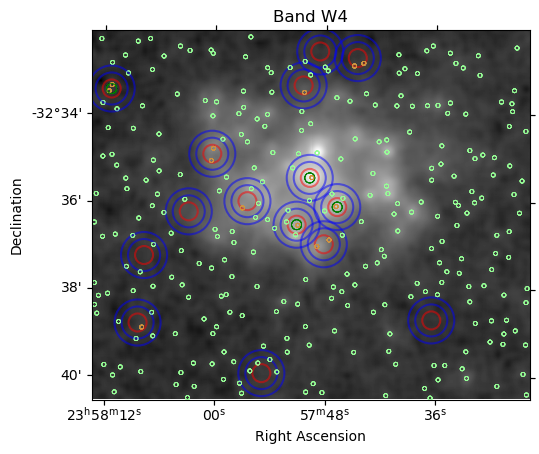

Band W3: 
https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0000/0000m334_ac51/0000m334_ac51-w3-int-3.fits
Grouped positions for galaxy NGC 7793 : [array([338.3505115 ,  78.45449761]), array([ 290.56827683, -278.95170799]), array([280.47663006, 140.61683632]), array([280.45069922, 154.97753585]), array([271.01763024, 171.99426245]), array([271.21485726, 267.9333709 ]), array([ 269.05731804, -162.94233658]), array([270.26077542, 254.31590617]), array([264.99428679, 340.36429687]), array([259.11421554, 508.64158776]), array([247.11580147, 229.52655448]), array([244.46135435, 191.59358016]), array([240.16908552, 223.10369499]), array([231.0526972, 154.4776201]), array([231.07464066, 508.81004271]), array([227.53549454, 346.94863862]), array([217.04781294, 220.7398476 ]), array([ 208.67114038, -231.76268447]), array([210.91892635, 313.02881592]), array([205.21803037, 134.27766184]), array([ 202.81241011, -105.57626316]), array([203.92357744, 174.00027023]), array([203.2420042

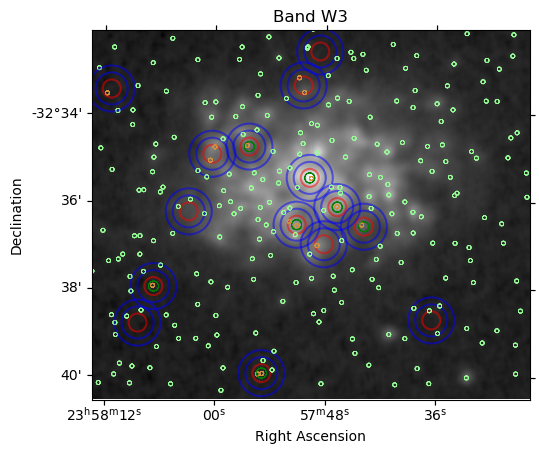

Band W2: 
https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0000/0000m334_ac51/0000m334_ac51-w2-int-3.fits
Grouped positions for galaxy NGC 7793 : [array([338.3505115 ,  78.45449761]), array([ 290.56827683, -278.95170799]), array([280.47663006, 140.61683632]), array([280.45069922, 154.97753585]), array([271.01763024, 171.99426245]), array([271.21485726, 267.9333709 ]), array([ 269.05731804, -162.94233658]), array([270.26077542, 254.31590617]), array([264.99428679, 340.36429687]), array([259.11421554, 508.64158776]), array([247.11580147, 229.52655448]), array([244.46135435, 191.59358016]), array([240.16908552, 223.10369499]), array([231.0526972, 154.4776201]), array([231.07464066, 508.81004271]), array([227.53549454, 346.94863862]), array([217.04781294, 220.7398476 ]), array([ 208.67114038, -231.76268447]), array([210.91892635, 313.02881592]), array([205.21803037, 134.27766184]), array([ 202.81241011, -105.57626316]), array([203.92357744, 174.00027023]), array([203.2420042

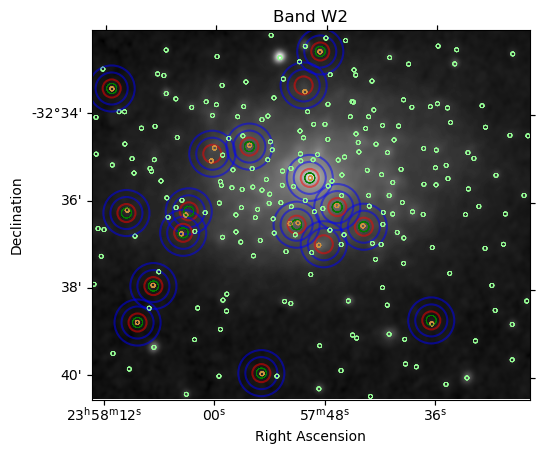

Band W1: 
https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0000/0000m334_ac51/0000m334_ac51-w1-int-3.fits
Grouped positions for galaxy NGC 7793 : [array([338.3505115 ,  78.45449761]), array([ 290.56827683, -278.95170799]), array([280.47663006, 140.61683632]), array([280.45069922, 154.97753585]), array([271.01763024, 171.99426245]), array([271.21485726, 267.9333709 ]), array([ 269.05731804, -162.94233658]), array([270.26077542, 254.31590617]), array([264.99428679, 340.36429687]), array([259.11421554, 508.64158776]), array([247.11580147, 229.52655448]), array([244.46135435, 191.59358016]), array([240.16908552, 223.10369499]), array([231.0526972, 154.4776201]), array([231.07464066, 508.81004271]), array([227.53549454, 346.94863862]), array([217.04781294, 220.7398476 ]), array([ 208.67114038, -231.76268447]), array([210.91892635, 313.02881592]), array([205.21803037, 134.27766184]), array([ 202.81241011, -105.57626316]), array([203.92357744, 174.00027023]), array([203.2420042

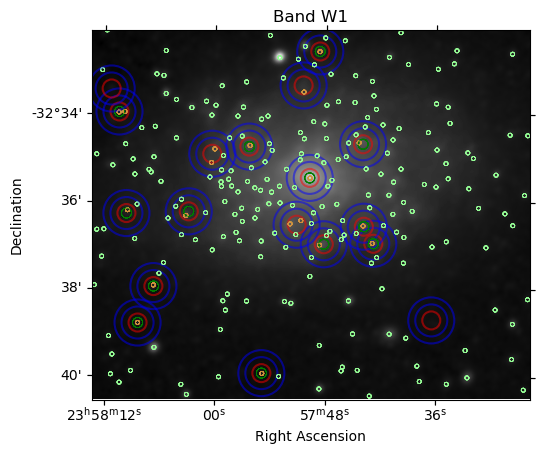

Number of valid sources:  65
Number of sources that dont 100 percent overlap x4 (because it is iterating over all 4 bands and appending each one once):  284
Number of sources coincidental with WISE bright points within 5 arcsec:  38

 all of the valid sources


band_id Galaxy Name  ObsID  Region           X           Y  Radius  \
0      {W4}    NGC 7793  14231       1  338.350512   78.454498       9   
8      {W4}    NGC 7793  14231       9  264.994287  340.364297       9   
11     {W4}    NGC 7793  14231      12  244.461354  191.593580       9   
13     {W4}    NGC 7793  14231      14  231.052697  154.477620       9   
15     {W4}    NGC 7793  14231      16  227.535495  346.948639       9   
16     {W4}    NGC 7793  14231      17  217.047813  220.739848       9   
18     {W4}    NGC 7793  14231      19  210.918926  313.028816       9   
21     {W4}    NGC 7793  14231      22  203.923577  174.000270       9   
29     {W4}    NGC 7793  14231      30  168.723070   25.828905       9   
34     {W4}    NGC 7793  14231      35  154.822914  197.524657       9   
39     {W4}    NGC 7793  14231      40  119.729934  244.847771       9   
41     {W4}    NGC 7793  14231      42   96.233525  187.342821       9   
47     {W4}    NGC 7793  14231      48   51.607015  143.734536       9   
49     {W4}    NGC 7793  14231      50   45.121974   76.355364       9   
54     {W4}    NGC 7793  14231      55   19.273696  310.000237       9   
71     {W3}    NGC 7793  14231       1  338.350512   78.454498       9   
75     {W3}    NGC 7793  14231       5  271.017630  171.994262       9   
82     {W3}    NGC 7793  14231      12  244.461354  191.593580       9   
84     {W3}    NGC 7793  14231      14  231.052697  154.477620       9   
86     {W3}    NGC 7793  14231      16  227.535495  346.948639       9   
87     {W3}    NGC 7793  14231      17  217.047813  220.739848       9   
89     {W3}    NGC 7793  14231      19  210.918926  313.028816       9   
92     {W3}    NGC 7793  14231      22  203.923577  174.000270       9   
100    {W3}    NGC 7793  14231      30  168.723070   25.828905       9   
104    {W3}    NGC 7793  14231      34  156.759968  251.990484       9   
110    {W3}    NGC 7793  14231      40  119.729934  244.847771       9   
112    {W3}    NGC 7793  14231      42   96.233525  187.342821       9   
117    {W3}    NGC 7793  14231      47   60.933147  112.737733       9   
120    {W3}    NGC 7793  14231      50   45.121974   76.355364       9   
125    {W3}    NGC 7793  14231      55   19.273696  310.000237       9   
142    {W2}    NGC 7793  14231       1  338.350512   78.454498       9   
146    {W2}    NGC 7793  14231       5  271.017630  171.994262       9   
153    {W2}    NGC 7793  14231      12  244.461354  191.593580       9   
155    {W2}    NGC 7793  14231      14  231.052697  154.477620       9   
157    {W2}    NGC 7793  14231      16  227.535495  346.948639       9   
158    {W2}    NGC 7793  14231      17  217.047813  220.739848       9   
160    {W2}    NGC 7793  14231      19  210.918926  313.028816       9   
163    {W2}    NGC 7793  14231      22  203.923577  174.000270       9   
171    {W2}    NGC 7793  14231      30  168.723070   25.828905       9   
175    {W2}    NGC 7793  14231      34  156.759968  251.990484       9   
181    {W2}    NGC 7793  14231      40  119.729934  244.847771       9   
183    {W2}    NGC 7793  14231      42   96.233525  187.342821       9   
186    {W2}    NGC 7793  14231      45   90.683863  165.929257       9   
188    {W2}    NGC 7793  14231      47   60.933147  112.737733       9   
191    {W2}    NGC 7793  14231      50   45.121974   76.355364       9   
193    {W2}    NGC 7793  14231      52   34.019105  185.651570       9   
196    {W2}    NGC 7793  14231      55   19.273696  310.000237       9   
213    {W1}    NGC 7793  14231       1  338.350512   78.454498       9   
216    {W1}    NGC 7793  14231       4  280.450699  154.977536       9   
217    {W1}    NGC 7793  14231       5  271.017630  171.994262       9   
220    {W1}    NGC 7793  14231       8  270.260775  254.315906       9   
226    {W1}    NGC 7793  14231      14  231.052697  154.477620       9   
228    {W1}    NGC 7793  14231      16  227.535495  346.948639       9   
229    {


 all of the Yes!! sources


band_id Galaxy Name  ObsID  Region           X           Y  Radius  \
11     {W4}    NGC 7793  14231      12  244.461354  191.593580       9   
16     {W4}    NGC 7793  14231      17  217.047813  220.739848       9   
21     {W4}    NGC 7793  14231      22  203.923577  174.000270       9   
54     {W4}    NGC 7793  14231      55   19.273696  310.000237       9   
75     {W3}    NGC 7793  14231       5  271.017630  171.994262       9   
82     {W3}    NGC 7793  14231      12  244.461354  191.593580       9   
87     {W3}    NGC 7793  14231      17  217.047813  220.739848       9   
92     {W3}    NGC 7793  14231      22  203.923577  174.000270       9   
100    {W3}    NGC 7793  14231      30  168.723070   25.828905       9   
104    {W3}    NGC 7793  14231      34  156.759968  251.990484       9   
117    {W3}    NGC 7793  14231      47   60.933147  112.737733       9   
142    {W2}    NGC 7793  14231       1  338.350512   78.454498       9   
146    {W2}    NGC 7793  14231       5  271.017630  171.994262       9   
153    {W2}    NGC 7793  14231      12  244.461354  191.593580       9   
157    {W2}    NGC 7793  14231      16  227.535495  346.948639       9   
158    {W2}    NGC 7793  14231      17  217.047813  220.739848       9   
163    {W2}    NGC 7793  14231      22  203.923577  174.000270       9   
171    {W2}    NGC 7793  14231      30  168.723070   25.828905       9   
175    {W2}    NGC 7793  14231      34  156.759968  251.990484       9   
183    {W2}    NGC 7793  14231      42   96.233525  187.342821       9   
186    {W2}    NGC 7793  14231      45   90.683863  165.929257       9   
188    {W2}    NGC 7793  14231      47   60.933147  112.737733       9   
191    {W2}    NGC 7793  14231      50   45.121974   76.355364       9   
193    {W2}    NGC 7793  14231      52   34.019105  185.651570       9   
196    {W2}    NGC 7793  14231      55   19.273696  310.000237       9   
216    {W1}    NGC 7793  14231       4  280.450699  154.977536       9   
217    {W1}    NGC 7793  14231       5  271.017630  171.994262       9   
220    {W1}    NGC 7793  14231       8  270.260775  254.315906       9   
226    {W1}    NGC 7793  14231      14  231.052697  154.477620       9   
228    {W1}    NGC 7793  14231      16  227.535495  346.948639       9   
229    {W1}    NGC 7793  14231      17  217.047813  220.739848       9   
242    {W1}    NGC 7793  14231      30  168.723070   25.828905       9   
246    {W1}    NGC 7793  14231      34  156.759968  251.990484       9   
254    {W1}    NGC 7793  14231      42   96.233525  187.342821       9   
259    {W1}    NGC 7793  14231      47   60.933147  112.737733       9   
262    {W1}    NGC 7793  14231      50   45.121974   76.355364       9   
264    {W1}    NGC 7793  14231      52   34.019105  185.651570       9   
265    {W1}    NGC 7793  14231      53   27.093983  287.066269       9   

     Annulus_Inner_Radius  Annulus_Outer_Radius  Net Flux (Jy)  \
11                     16                    23       0.012291   
16                     16                    23       0.019013   
21                     16                    23       0.008378   
54                     16                    23       0.122127   
75                     16                    23       0.000795   
82                     16                    23       0.010702   
87                     16                    23       0.029025   
92                     16                    23       0.006010   
100                    16                    23       0.000596   
104                    16                    23       0.000505   
117                    16                    23       0.000183   
142                    16                    23       0.000029   
146                    16                    23       0.000290   
153                    16                    23       0.000061   
157                    16                    23       0.000171   
158                    16                    23       0.00632

band_id Galaxy Name  ObsID  Region           X           Y  Radius  \
0      {W4}    NGC 7793  14231       1  338.350512   78.454498       9   
1      {W4}    NGC 7793  14231       2  290.568277 -278.951708       9   
2      {W4}    NGC 7793  14231       3  280.476630  140.616836       9   
3      {W4}    NGC 7793  14231       4  280.450699  154.977536       9   
4      {W4}    NGC 7793  14231       5  271.017630  171.994262       9   
5      {W4}    NGC 7793  14231       6  271.214857  267.933371       9   
6      {W4}    NGC 7793  14231       7  269.057318 -162.942337       9   
7      {W4}    NGC 7793  14231       8  270.260775  254.315906       9   
8      {W4}    NGC 7793  14231       9  264.994287  340.364297       9   
9      {W4}    NGC 7793  14231      10  259.114216  508.641588       9   
10     {W4}    NGC 7793  14231      11  247.115801  229.526554       9   
11     {W4}    NGC 7793  14231      12  244.461354  191.593580       9   
12     {W4}    NGC 7793  14231      13  240.169086  223.103695       9   
13     {W4}    NGC 7793  14231      14  231.052697  154.477620       9   
14     {W4}    NGC 7793  14231      15  231.074641  508.810043       9   
15     {W4}    NGC 7793  14231      16  227.535495  346.948639       9   
16     {W4}    NGC 7793  14231      17  217.047813  220.739848       9   
17     {W4}    NGC 7793  14231      18  208.671140 -231.762684       9   
18     {W4}    NGC 7793  14231      19  210.918926  313.028816       9   
19     {W4}    NGC 7793  14231      20  205.218030  134.277662       9   
20     {W4}    NGC 7793  14231      21  202.812410 -105.576263       9   
21     {W4}    NGC 7793  14231      22  203.923577  174.000270       9   
22     {W4}    NGC 7793  14231      23  203.242004  196.738371       9   
23     {W4}    NGC 7793  14231      24  197.490140  300.203701       9   
24     {W4}    NGC 7793  14231      25  189.957758  320.956428       9   
25     {W4}    NGC 7793  14231      26  185.208778  -80.405696       9   
26     {W4}    NGC 7793  14231      27  186.801720  537.153164       9   
27     {W4}    NGC 7793  14231      28  178.425445  435.104226       9   
28     {W4}    NGC 7793  14231      29  177.474172  390.128515       9   
29     {W4}    NGC 7793  14231      30  168.723070   25.828905       9   
30     {W4}    NGC 7793  14231      31  168.322402  345.437876       9   
31     {W4}    NGC 7793  14231      32  157.822772  173.408394       9   
32     {W4}    NGC 7793  14231      33  158.527219  388.384362       9   
33     {W4}    NGC 7793  14231      34  156.759968  251.990484       9   
34     {W4}    NGC 7793  14231      35  154.822914  197.524657       9   
35     {W4}    NGC 7793  14231      36  146.870782  380.359862       9   
36     {W4}    NGC 7793  14231      37  127.403650  318.646196       9   
37     {W4}    NGC 7793  14231      38  124.678056  342.310637       9   
38     {W4}    NGC 7793  14231      39  121.727271  310.238714       9   
39     {W4}    NGC 7793  14231      40  119.729934  244.847771       9   
40     {W4}    NGC 7793  14231      41  116.613502  343.668538       9   
41     {W4}    NGC 7793  14231      42   96.233525  187.342821       9   
42     {W4}    NGC 7793  14231      43   94.982779  480.574381       9   
43     {W4}    NGC 7793  14231      44   94.371357  606.797655       9   
44     {W4}    NGC 7793  14231      45   90.683863  165.929257       9   
45     {W4}    NGC 7793  14231      46   77.722270  516.245216       9   
46     {W4}    NGC 7793  14231      47   60.933147  112.737733       9   
47     {W4}    NGC 7793  14231      48   51.607015  143.734536       9   
48     {W4}    NGC 7793  14231      49   50.848448  187.203587       9   
49     {W4}    NGC 7793  14231      50   45.121974   76.355364       9   
50     {W4}    NGC 7793  14231      51   42.197187  282.496425       9   
51     {W4}    NGC 7793  14231      52   34.019105  185.651570       9   
52     {W4}    NGC 7793  14231      53   27.093983  287.066269       9   
53     {

65


In [36]:
####Defining the constants
# defining a function to calculate the distances between two sources.
def dist(p1, p2):
   return np.sqrt( (p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )


#defining a function that creates a circular mask around each source so that if something overlaps with it, that overlapping part is not included in the aperture photometry
def create_circular_mask(h,w,center,radius):
   Y, X = np.ogrid[:h, :w] # creating an open (more memory efficient) coordinate grid of the image
   dist_from_center = np.sqrt((X-center[0])**2+ (Y-center[1])**2)
   mask = dist_from_center <= radius # so that everything inside the radius receives a mask
   return mask

def overlap_area(radius, distance):
    Area = ((2 * radius**2) * np.arccos((distance / (2 * radius)))) - ( .5 * distance * np.sqrt( (4 * radius**2) - distance**2))
    return Area



# define a mapping of the bands into labels to make it easier
band_labels = {'w1': 'W1', 'w2': 'W2', 'w3': 'W3', 'w4': 'W4'}
flux_zmfd = {'w1': 309.54 ,'w2': 171.787,'w3': 31.674,'w4': 8.363} # check if these worked by looking at the band 4 code above
instr_zpmag = {'w1': 20.73,'w2': 19.56,'w3': 17.6 ,'w4':12.98 }
wavelengths = {'w1': 3.4 ,'w2': 4.6,'w3': 12,'w4': 22}


#define function to get flux density per unit frequency (energy units)
def flux_dens(net_flx, net_flx_err, wavelength):
   flux_density = (net_flx * 1e-23) * (3e10 / (wavelength*1e-4)**2)
   flux_density_unc = (net_flx_err * 1e-23) * (3e10 / (wavelength*1e-4)**2)
   return flux_density, flux_density_unc


'''
make a conditional code where:
choose one obs id and eerything associated with it bwith the longest exposuretime exptime?
tell me all of the obsids associated with this galaxy_name
    unique list of each galaxy Name
    what are the obs ids associated with it
    if more than one which one is the longest exposure
    aggregate all of the associated sources with it and none from any of the others


'''


#import huge csv and grab the name and ra and dec needed for each galaxy.
targetgals = pd.read_csv('../Data/inWISE.csv') # this should not be the one for all 120 and should rather be for the 74 of them.
#print(targetgals[0:20])
huge = pd.read_csv('../Data/Hugefiles/Source_Flux_All_Modified_5.csv')
columns = ['RA','Dec','Gname_Modified','Gname_Homogenized', 'ObsID', 'EXPOSURE']
g_huge = huge[columns]
#display(g_huge.head())


#group the x-ray sources for this galaxy. locate through merging
df1 = targetgals
df2 = g_huge




merged_data = pd.merge(df1, df2, left_on='source_id', right_on = 'Gname_Homogenized', how='inner')
columns1 = ['RA','Dec','Gname_Homogenized', 'ObsID', 'EXPOSURE']
Xray_sources = merged_data[columns1]


#group by galaxy name and the longest exposure time.
longest_exposure_obs = Xray_sources.loc[Xray_sources.groupby('Gname_Homogenized')['EXPOSURE'].idxmax()]


# aggregate all the sources associated with the obsid with the longest exposure time
aggregated_sources = Xray_sources[Xray_sources['ObsID'].isin(longest_exposure_obs['ObsID'])]




#align them based on source Id since they all got jumbled.
#aligned_targetgals = targetgals[targetgals.isin(aggregated_sources['Gname_Homogenized'])]


#reset index and group them by name
#aligned_targetgals = aligned_targetgals.reset_index(drop=True)
#print(aligned_targetgals)
#aligned_aggregatedsources = aggregated_sources.groupby('Gname_Homogenized')






'''
print("Unique list of each galaxy name:")
print(targetgals['source_id'])


print("\nObservations with the longest exposure time for each galaxy:")
print(longest_exposure_obs)


print("\nAggregated sources:")
print(aggregated_sources)
#'''












# Ensure the uniqueness for NGC 5128
#ngc_5128_sources = Xray_sources[Xray_sources['Gname_Homogenized'] == 'NGC 5128']
#print(f"Number of unique X-ray sources for NGC 5128: {len(ngc_5128_sources)}")
#print(ngc_5128_sources)


pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
#display(g_huge)
#display(Xray_sources)








#create a list of all the names needed
galaxy_names = targetgals['source_id'].unique()




galaxy_sources = {}
grouped_sources = aggregated_sources.groupby('Gname_Homogenized')
'''print("\nGrouped sources:")
for group_name, group in grouped_sources:
   print(f"\nGroup: {group_name}")
   print(group)'''
#get all of the ra and dec sources for the galaxy in question
for group_name, group in grouped_sources:
   galaxy_sources[group_name] = {'ra' : group['RA'].values, 'dec' : group['Dec'].values, 'ObsID': group['ObsID'].values}
  






#### initialize everything

#overlap_percent = []
#distance = []























rows = []
#create subsets for testing:
#grouped_sources_subset = grouped_sources.head(2)
#targetgals_subset = targetgals.head(2)


targetgals_subset = targetgals.iloc[29:30]



# Lookup and define a service for ALLWISE Atlas images
allwise_service = vo.dal.SIAService("https://irsa.ipac.caltech.edu/ibe/sia/wise/allwise/p3am_cdd?")
#loop through the galaxies
print("\nAligned target galaxies and grouped sources:")


for galaxy in targetgals_subset.itertuples():
    galaxy_name = galaxy.source_id
    print(galaxy_name)
    #group = aligned_aggregatedsources.get_group(galaxy_name)
  
    # Print galaxy information
    #print(f"\nGalaxy: {galaxy_name}")
    #print(group)


    #define coordinates
    ra1 = galaxy.ra_x
    #print (ra1)
    dec1 = galaxy.dec_x
    pos = SkyCoord(ra=ra1, dec=dec1, unit= 'deg')
    #search the service for images covering within 1 arcsecond of the star. make this bigger if needed
    im_table = allwise_service.search(pos=pos, size= 1*u.arcsec)
    #im_table
    im_table.to_table().colnames
    print(im_table)
    # get the Ra and dec values necessary for the kdtree and rest of the code
    if galaxy_name in galaxy_sources:
       ra = galaxy_sources[galaxy_name]['ra']
       dec = galaxy_sources[galaxy_name]['dec']
       obsid = galaxy_sources[galaxy_name]['ObsID']
       print(f"Galaxy: {galaxy_name}")
       print("RA values:", ra)
       print("Number of RA values:", len(ra))
    else:
       print(f"No sources found for galaxy: {galaxy_name}")
          
   ##running the for loop over every image and doing aperture photometry on each one
   #currently outputs as w4,w1,w2,w3 when querying the images. so index is 0.1.2.3 i want the index to be 0.3.2.1

    for i in [0, 3, 2, 1]:  # Reverse order index
        band_id = im_table[i]["sia_bp_id"].lower()  # Get band ID in lowercase
        if band_id in band_labels:
            print(f'Band {band_labels[band_id]}: ')
            data_url = im_table[i].getdataurl()
            #Download the image and open it in Astropy
            fname = download_file(data_url, cache=True)
            image1= fits.open(fname)
            image_data= image1[0].data
            #print(data)
            print(data_url)
            wcs = WCS(image1[0].header)
            #cuting out the image of the galaxy apart from the rest of the background.
            cutout = Cutout2D(image_data, pos, (437,437), wcs=wcs)
            wcs = cutout.wcs
            cutout_data = cutout.data
            #print(cutout_data)
            positions = wcs.world_to_pixel_values(ra, dec)
            positions = np.array(list(zip(positions[0], positions[1])))


            #define the distance threshold for the KDTree grouping (in pixels)
            distance_threshold = 5


            #build the KDTree for efficient grouping
            tree = KDTree(positions)


            #query the KDTree to find points within the defined radius of dist threshold and group them together
            groups = tree.query_ball_tree(tree, r=distance_threshold)
            # print(groups)
            # consolidating the groups. 'unique_groups' and 'seen': These are used to ensure that each group is processed only once.
            unique_groups = []
            seen = set()
            for group in groups:
                group = tuple(sorted(group))
                if group not in seen:
                    seen.add(group)
                    unique_groups.append(group)
                 # print(unique_groups)
            # for each unique group, the average postion of the detections is calulated so that only one source detection is used for aperture photometry instead of a bunch of the same sources being used.
             #represents the consolidated postion of potentially multiple detections of one source.
            grouped_positions = [positions[list(group)].mean(axis=0) for group in unique_groups]
            #print(grouped_positions)

            print("Grouped positions for galaxy", galaxy_name, ":", grouped_positions)
            #define the Region(s) Of Interest (center x, center y, radius)
            ROI = [ ((x, y) , 9, 16, 23) for x,y in grouped_positions ] # (x, y, radius around target, inner r, outer r)   36.3636, 50.90909) may need to mke the radius bigger when goruping?
          


                # initialize valid rows plotting for the current image iteration
            valid_rows = []
           
           #now inputting the aperture photometry part
           # check for overlap and perform aperture photometry
            for i, ((x, y), r, annulus_inner, annulus_outer) in  enumerate(ROI):
                overlap_dict = []
                overlap = False # initialize overlap flag (A boolean flag overlap is set to False for each source to track if it overlaps with any other source. becomes true if they do overlap 
                acc_overlap = False # initialize the acceptable overlap flag.  false if there is no overlap, true if there is overlap and it is acceptable 
               

                for j, ((x2, y2), r2, annulus_inner2, annulus_outer2) in  enumerate(ROI): # apparently you can run a for loop over 2 objects by putting the second one inside the first. it iterates over every source again to then see if it overlaps at all with another source.
                    if i != j: # ensures that a source is not compared to itself! wow
                        #print(f'{x}, {y} / {x2}, {y2}')
                        print(f"Checking positions: ({x}, {y}) and ({x2, {y2}})")
                        distance = dist((x, y) , (x2, y2))
                        print(f"Distance: {distance}, Radii Sum: {r + r2}")
                        #print('dsitance', distance)
                        print('Distance', distance)
                        print('r1', r)
                        if distance < r + r2:  # if the distance is less than the size of the two radii added together, then they are overlapping.
                            print(distance)
                            print('yesif')
                            overlap_percent = (r + r2 - distance)/(r+r2)  # the amount they are overlapping divided by the total size of radii distance
                            #print('overlap perc', overlap_percent)
                            if overlap_percent > .5:
                                overlap = True # this way, if they overlap by more than 50% then they will not be usable because less than 50% of the flux extractable area can be seen.
                                #print('overlap is unacceptable: ', overlap)
                                overlap_aperture = np.nan
                                overlap_photo_table = np.nan
                                overlap_counts = np.nan
                                overlap_error = np.nan
                              
                            elif overlap_percent <= .5:
                                acc_overlap = True
                                #print('acceptable or no overlap: ', acc_overlap)
                                #Handle overlaps that are acceptable (less than the threshold, but still overlapping by a small percent)
                                overlap_aperture = CircularAperture((x2, y2), r2)
                                overlapping_area = overlap_area(r,distance) # using the function to define the overlapping area for the location of overlap
                                overlap_photo_table = aperture_photometry(cutout_data, overlap_aperture)
                                total_area = math.pi * r**2
                                overlap_counts = overlap_photo_table['aperture_sum'][0] * ( overlapping_area/total_area ) # scaling the counts by the overlapping area
                                overlap_error = np.sqrt(overlap_counts)
                                overlap_dict.append({'Position': ({x}, {y}),  'overlapping counts': overlap_counts, 'overlap_error': overlap_error})
                                print('were here')
                                print('Overlap counts', overlap_counts)
                                print('overlapdict', overlap_dict)



                        else:
                            print(' Prob skips distance if statement')
                            #print('not overlapping at all')
                            overlap_percent = np.nan
                            overlap_aperture = np.nan
                            overlap_photo_table = np.nan
                            overlap_counts = np.nan
                            overlap_error = np.nan

                       
                print(acc_overlap)  
                if acc_overlap:
                    overlap_counts = 0
                    overlap_error = 0
                    # for a source, if it overlaps with more than one other source, add all of the counts for those overlapping regions
                    for row in overlap_dict:
                        if not np.isnan(row['overlapping counts']) and not np.isnan(row['overlap_error']):
                            overlap_counts += row['overlapping counts'] # now add in quadriture for the propagation of error for sources like this
                            overlap_error += row['overlap_error']**2
                    overlap_error= np.sqrt(overlap_error)
                    print('Overlapping COUNTS HERE', overlap_counts)
                    # For the Target objects in the little aperture circle define their target apertures
                    target_aperture = CircularAperture((x,y),r,)
                   
                    #perform aperture photometry on target
                    target_photo_table = aperture_photometry(cutout_data, target_aperture)
                    target_counts = target_photo_table['aperture_sum'][0]

                    target_counts -= overlap_counts
                    # so that i dont take the log or sqrt of a negative number or zero and get an error
                    if target_counts > 0: #
                        target_error= np.sqrt(target_counts)
                        #propagated error of overlap error
                        target_overlap_counts_err = np.sqrt(target_error**2 + overlap_error**2)
                        #print(target_counts)
                        if band_id in flux_zmfd and instr_zpmag:
                            #print(f'Band {flux_zmfd[band_id]}: ')
                            flx_conv_fact = flux_zmfd[band_id]
                            M0instr = instr_zpmag[band_id]
                            Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
                            target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
                          
                            #propagation of uncertainty of flux conversion
                            Mcal_error = (2.5*target_overlap_counts_err) / (target_counts * np.log(10))
                            target_flux_error = target_flux * np.log(10) * (Mcal_error/2.5)


                    else:# to handle the cases where the counts are not more than 0 and if the conversion factors are missing.
                        target_error = np.nan
                        target_overlap_counts_err = np.nan
                        target_flux = np.nan
                        target_flux_error = np.nan
                        flx_conv_fact = np.nan
                        M0instr = np.nan
                        target_counts = np.nan

                    # continuing on with the photometry under the "if acc_overlap"


                    #calculate area of target aperutue
                    target_area = target_aperture.area

                    # For the Background Annuli of outside of the Target
                    #define the background annulus for the target
                    annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)


                    #perform aperture photometry on annuli
                    annulus_photo_table = aperture_photometry(cutout_data, annulus_aperture)
                    annulus_counts = annulus_photo_table['aperture_sum'][0]
                  
              
                    if annulus_counts > 0:
                        overlapannulus_error = np.sqrt(annulus_counts) # the error of the annulus for sources that overlap
                        # to avoid taking the log of zero or negative value
                        if band_id in flux_zmfd and instr_zpmag:
                            #print(f'Band {flux_zmfd[band_id]}: ')
                            flx_conv_fact = flux_zmfd[band_id]
                            M0instr = instr_zpmag[band_id]
                            Mcal_trgt = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
                            annulus_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux


                            #propagation of uncertainty of flux conversion
                            Mcal_error_ann = (2.5 * overlapannulus_error) / (annulus_counts * np.log(10))
                            annulus_flux_error = annulus_flux * np.log(10) * (Mcal_error_ann/2.5)




                    else: 
                        annulus_flux = np.nan # to handle the cases where the counts are not more than 0 and if the conversion factors are missing.
                        overlapannulus_error = np.nan
                        flx_conv_fact = np.nan
                        M0instr = np.nan
                        annulus_counts = np.nan
                          
                    #calculate area of annulus
                    annulus_area = annulus_aperture.area


                    # do the calculations for including a Background aperture
              
                    #Calculating the net flux:
                    #calculate the mean background per pixel
                    bg_perpixel = annulus_flux/annulus_area
                    bg_perpixel_err = annulus_flux_error/annulus_area #propagation of error!


                    #calculate the total background in the target aperture
                    tot_bg = bg_perpixel * target_area
                    tot_bg_err = bg_perpixel_err * target_area ##propagation of error!


                    #Subtract background from the target flux
                    net_flx = target_flux - tot_bg
                    net_flx_err = np.sqrt(target_flux_error**2 + tot_bg_err**2) ##propagation of error!
              
                    #flag the sources that overlap
                    rows.append({ 'band_id': {band_labels[band_id]}, 'Galaxy Name' : galaxy_name, 'ObsID' : obsid[0], 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner,
                           'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx,'Flux Uncertainty': net_flx_err, 'Flag':'Valid' if not np.isnan(np.array(target_counts)) and target_counts > 0 and net_flx > 0 else 'Nan values or Low Flux',
                           'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux, 'Acceptable overlapping?': 'Yes' if acc_overlap == True else 'Not acceptable or no overlap at all', 'Unacceptable overlapping?': 'Yes' if overlap == True else 'Acceptable or no overlap at all',
                               'Annulus Counts': annulus_counts, 'Overlap Counts': overlap_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': cutout_data.shape, 'Flux Conv':flx_conv_fact, 'MzpInstr':M0instr,
                               'Offset in Arcseconds': [], 'Exists?': 'No', 'Point Source Position' : [], 'Target Error': target_flux_error, 'Annulus Error': annulus_flux_error, 'Overlap Error (in counts)': overlap_error, 'Wavelength': wavelengths[band_id], 'Flux Density': [], 'Flux Density Uncertainty' : [] })
                    # Append valid results to valid_rows
                    valid_rows.append({
                       'band_id': {band_labels[band_id]},  'Galaxy Name' : galaxy_name, 'ObsID' : obsid[0],
                       'Region': i+1, 'X': x, 'Y': y, 'Radius': r,
                       'Annulus_Inner_Radius': annulus_inner,
                       'Annulus_Outer_Radius': annulus_outer,
                       'Net Flux (Jy)': net_flx, 'Flux Uncertainty': net_flx_err,'Flag':'Valid' if not np.isnan(np.array(target_counts)) and target_counts > 0 and net_flx > 0 else 'Nan values or Low Flux', 'Flux Conv':flx_conv_fact, 'MzpInstr':M0instr,
                       'Offset in Arcseconds': [], 'Exists?': 'No', 'Point Source Position' : [],  'Target Error': target_flux_error, 'Annulus Error': annulus_flux_error, 'Overlap Error (in counts)': overlap_error, 'Wavelength': wavelengths[band_id], 'Flux Density': [], 'Flux Density Uncertainty' : [] })
                  
                else: #perform all the normal aperture photometry stuff for those that do not overlap in any way.
            
                   # For the Target objects in the little aperture circle define their target apertures
                    target_aperture = CircularAperture((x,y),r,)
              
                    #perform aperture photometry on target
                    target_photo_table = aperture_photometry(cutout_data, target_aperture)
                    target_counts = target_photo_table['aperture_sum'][0]


                    if target_counts > 0:   # avoid taking the log of zero or negative value
                        target_error = np.sqrt(target_counts)
                        if band_id in flux_zmfd and instr_zpmag:
                            #print(f'Band {flux_zmfd[band_id]}: ')
                            flx_conv_fact = flux_zmfd[band_id]
                            M0instr = instr_zpmag[band_id]
                            Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
                            target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux


                            #propagation of uncertainty of flux conversion
                            Mcal_error = (2.5*target_error) / (target_counts * np.log(10))
                            target_flux_error = target_flux * np.log(10) * (Mcal_error/2.5)


                    else:
                        target_error = np.nan
                        target_flux = np.nan
                        target_flux_error = np.nan
                        flx_conv_fact = np.nan
                        M0instr = np.nan
                        target_counts = np.nan

                      
                    #calculate area of target aperutue
                    target_area = target_aperture.area




                    # For the Background Annuli of outside of the Target
                    #define the background annulus for the target
                    annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)


                    #perform aperture photometry on annuli
                    annulus_photo_table = aperture_photometry(cutout_data, annulus_aperture)
                    annulus_counts = annulus_photo_table['aperture_sum'][0]
                    # the error of the annulus for sources that overlap
                  
                    if annulus_counts > 0:
                        annulus_error = np.sqrt(annulus_counts)
                        # avoid taking the log of zero or negative value
                        if band_id in flux_zmfd and instr_zpmag:
                            #print(f'Band {flux_zmfd[band_id]}: ')
                            flx_conv_fact = flux_zmfd[band_id]
                            M0instr = instr_zpmag[band_id]
                            Mcal_trgt = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
                            annulus_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux


                            #propagation of uncertainty of flux conversion
                            Mcal_error_ann = (2.5 * annulus_error) / (annulus_counts * np.log(10))
                            annulus_flux_error = annulus_flux * np.log(10) * (Mcal_error_ann/2.5)
                    else:
                        annulus_flux = np.nan # to handle the cases where the counts are not more than 0 and if the conversion factors are missing.
                        annulus_error = np.nan
                        annulus_flux_error = np.nan
                        flx_conv_fact = np.nan
                        M0instr = np.nan
                        annulus_counts = np.nan
                          
                    #calculate area of annulus
                    annulus_area = annulus_aperture.area


                    # do the calculations for including a Background aperture
              
                    #Calculating the net flux:
                    #calculate the mean background per pixel
                    bg_perpixel = annulus_flux/annulus_area
                    bg_perpixel_err = annulus_flux_error/annulus_area #propagation of error!


                    #calculate the total background in the target aperture
                    tot_bg = bg_perpixel * target_area
                    tot_bg_err = bg_perpixel_err * target_area ##propagation of error!


                    #Subtract background from the target flux
                    net_flx = target_flux - tot_bg
                    net_flx_err = np.sqrt(target_flux_error**2 + tot_bg_err**2) ##propagation of error!

                    if overlap:
                        overlap_counts = np.nan
                        overlap_error = np.nan
                        target_counts = np.nan

                    #   Append the result as a dictionary to the list named 'rows'
                    rows.append({ 'band_id': {band_labels[band_id]}, 'Galaxy Name' : galaxy_name, 'ObsID' : obsid[0], 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner,
                           'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx, 'Flux Uncertainty': net_flx_err,  'Flag':'Valid' if not np.isnan(np.array(target_counts)) and target_counts > 0 and net_flx > 0 else 'Nan values or Low Flux',
                           'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux, 'Acceptable overlapping?': 'Yes' if acc_overlap == True else 'Not acceptable or no overlap at all','Unacceptable overlapping?': 'Yes' if overlap == True else 'Acceptable or no overlap at all',
                               'Annulus Counts': annulus_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': cutout_data.shape, 'Flux Conv':flx_conv_fact, 'MzpInstr':M0instr,
                               'Offset in Arcseconds': [],   'Exists?': 'No', 'Point Source Position' : [], 'Target Error': target_flux_error, 'Annulus Error': annulus_flux_error, 'Overlap Error (in counts)': [], 'Wavelength': wavelengths[band_id],'Flux Density': [], 'Flux Density Uncertainty' : [] })  #will prolly have to change the name of the Flux here!!!
                        #"Low Flux" means that they either have zero flux or negative flux and so they are excluded from the plotting
              
                    # Append valid results to valid_rows
                    valid_rows.append({
                       'band_id': {band_labels[band_id]}, 'Galaxy Name' : galaxy_name, 'ObsID' : obsid[0],
                       'Region': i+1, 'X': x, 'Y': y, 'Radius': r,
                       'Annulus_Inner_Radius': annulus_inner,
                       'Annulus_Outer_Radius': annulus_outer,
                       'Net Flux (Jy)': net_flx, 'Flux Uncertainty': net_flx_err,
                       'Flag':'Valid' if not np.isnan(np.array(target_counts)) and target_counts > 0 and net_flx > 0 else 'Nan values or Low Flux',
                       'Flux Conv':flx_conv_fact, 'MzpInstr':M0instr, 'Exists?': 'No', 'Point Source Position' : [], 'Offset in Arcseconds': [],
                       'Target Error': target_flux_error, 'Annulus Error': annulus_flux_error, 'Overlap Error (in counts)': [], 'Wavelength': wavelengths[band_id], 'Flux Density': [], 'Flux Density Uncertainty' : [] })




            #Source detection code
            mean, median, std = sigma_clipped_stats(cutout_data, sigma=3.0) 
            #print((mean, median, std))


            # subtract the background and find FWHM of sources at a certain threshold
            #started at fwhm= 3 and threshold = 5
            daofind = DAOStarFinder(fwhm=8, threshold=1*std) # find the stars in the image that have FWHMs of around 3 pixels and have peaks approximately 5-sigma above the background.
            sources = daofind(cutout_data - median) 
            #print(type(sources))
            # will likely run into iissues in the code below
            for col in sources.colnames: 
                if col not in ('id', 'npix'):
                    sources[col].info.format = '%.2f'  # for consistent table output
                        # sources.pprint(max_width=3000) 


                        #likely the flux labeled in this is not converted!
          
            # plot the image with marked locations of all the sources it detected.
            detected_positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
            apertures = CircularAperture(detected_positions, r=2)




            # Plotting for current image
            # Filter valid rows
            valid_rows_filtered = [row for row in valid_rows if row['Flag'] == 'Valid']
          
            # Was there a point source there?
            pixelsinarc = 0.0003819444391411 * 3600 ## 0.0003819444391411 is the number found in the header of the image for the scale of pixels in degrees for the fits image.
            detectedpos_all = []
            #rows = [row for row in rows if row['Flag'] == 'Valid']
            for row in valid_rows_filtered:
                apertures_forced = CircularAperture((row['X'], row['Y']), r=row['Radius'])
                for detected_position in detected_positions:
                    detected_x, detected_y = detected_position
                    distance = dist((row['X'], row['Y']), (detected_x, detected_y) ) #distance from the center of the xray source to the center of the detected source
                    if distance <= row['Radius']:
                        row['Exists?'] = 'Point Source Detected'
                        row['Point Source Position'].append((detected_x, detected_y))
                        dist_in_arc = distance * pixelsinarc
                        row['Offset in Arcseconds'].append((dist_in_arc))
                        detectedpos_all.append(detected_position)



            Yes = []
            YesRadius= 5
            for row in valid_rows_filtered:
                        apertures_forced = CircularAperture((row['X'], row['Y']), r=row['Radius'])
                        for detected_position in detected_positions:
                            detected_x, detected_y = detected_position
                            distance = dist((row['X'], row['Y']), (detected_x, detected_y) )
                            if distance <= YesRadius:
                                row['Exists?'] = 'Yes!!'
                                Yes.append((row['X'], row['Y']))
                                #else: # this does not seem to do what i want it to do
                               #row['Exists?'] = 'Detected but does not exist'
                               
            #doing flux density
            for row in valid_rows_filtered:
                net_flx = row['Net Flux (Jy)']
                net_flx_err = row['Flux Uncertainty']
                wavelength = row['Wavelength']
                #print(net_flx)
                flux_density, flux_density_unc = flux_dens(net_flx, net_flx_err, wavelength)
                row['Flux Density'].append(flux_density)
                row['Flux Density Uncertainty'].append(flux_density_unc)
                  
          
            # Update rows with valid_rows_filtered information
            for valid_row in valid_rows_filtered:
                for row in rows:
                    if row['band_id'] == valid_row['band_id'] and row['Region'] == valid_row['Region']:
                        row.update(valid_row)


            #print('valid sources', valid_rows_filtered)


            #print( len(detectedpos_all))
            if len(detectedpos_all) > 0:
                apertures_detected = CircularAperture(detectedpos_all, r=2)
            if len(Yes) > 0:
                apertures_Yes = CircularAperture(Yes, r=YesRadius)
          
         # xc = 244.422687    #19.014239
        # yc=  191.596758# 310.340772
      
                

           # Plotting for current image
            
            fig, ax = plt.subplots(subplot_kw={'projection': wcs})
            norm = ImageNormalize(cutout.data, stretch=SqrtStretch())
            for row in valid_rows_filtered: # use 'valid_rows_filtered' to change it back to only the valid sources. use 'rows' to plot all sources
                target_aperture = CircularAperture((row['X'], row['Y']), row['Radius'])
                annulus_aperture = CircularAnnulus((row['X'], row['Y']), row['Annulus_Inner_Radius'], row['Annulus_Outer_Radius'])
                target_aperture.plot(color='red', lw=1.5, alpha=.5, ax=ax)
                annulus_aperture.plot(color='blue', lw=1.5, alpha=.5, ax=ax)
              
                apertures.plot(color='#98ff98', lw=.5, alpha=0.5)
                apertures_detected.plot(color='#FF4500', lw=.5, alpha=0.5)  #  #FF69B4 for hot pink
                apertures_Yes.plot(color='green', lw=.5, alpha=0.5)


                # curious ones
            # curious = CircularAperture((xc,yc),5)
            # curious.plot(color='red', lw=.5, alpha=0.5)
            ax.imshow(cutout.data, cmap='gray', norm=norm, interpolation='nearest')
            ax.set_xlabel('Right Ascension')
            ax.set_ylabel('Declination')
            plt.title(f'Band {band_labels[band_id]}')
            plt.show()
            yesses =[row for row in valid_rows_filtered if row['Exists?'] == 'Yes!!']
            #'''
   
           


  


      
      






display_data = pd.DataFrame(rows)
#by_name = display_data.groupby('Galaxy Name')
#byname = by_name.apply(lambda x: x).reset_index(drop=True)
#print("\n FINAL Sources Grouped by Galaxy:")
#display(byname)
#byname_byband = by_name.groupby('band_id')
#display(byname_byband)


#pd.set_option("display.max_rows", None)
#pd.set_option("display.max_columns", None)
print('Number of valid sources: ',len(display_data.loc[display_data['Flag']== 'Valid']))
print('Number of sources that dont 100 percent overlap x4 (because it is iterating over all 4 bands and appending each one once): ',len(display_data))
print('Number of sources coincidental with WISE bright points within 5 arcsec: ',len(display_data.loc[display_data['Exists?']== 'Yes!!']))

print("\n all of the valid sources")
display(display_data.loc[display_data['Flag']== 'Valid'])
print("\n all of the Yes!! sources")
display(display_data.loc[display_data['Exists?']== 'Yes!!'])

display(display_data)
print(len(display_data.loc[display_data['Flag']== 'Valid']))






  
#'''



In [36]:
testing = display_data.loc[display_data['Flag']== 'Valid']
np.isnan(np.array(testing.head(1)['Target Counts'])[0])

#display_data.head()

True